<a href="https://colab.research.google.com/github/JacquelineeJia/datathon4-Team14-CHL5230-F23/blob/main/AdaBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries

!pip install category_encoders

import pandas as pd
import numpy as np
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
import pandas as pd
import io

# Upload the CSV file
uploaded = files.upload()

# Use the file name to access the content in the dictionary
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Display the first few rows of the dataset to ensure it's loaded correctly
df.head()

Saving datathon4.csv to datathon4.csv


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Preparation

In [ ]:
#check dataset shape, variable types, and missing values
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(91713, 186)
encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object
encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64


Set up model

In [ ]:
data = df[['apache_4a_icu_death_prob', 'ethnicity','pre_icu_los_days', 'd1_spo2_max', 'd1_spo2_min', 'd1_mbp_min', 'd1_mbp_max',
 'pre_icu_los_days', 'hepatic_failure', 'solid_tumor_with_metastasis', 'icu_type', 'gender', 'icu_stay_type', 'age', 'd1_sodium_max', 'd1_hemaglobin_max', 'd1_potassium_min']]

In [ ]:
data.dtypes

apache_4a_icu_death_prob       float64
ethnicity                       object
pre_icu_los_days               float64
d1_spo2_max                    float64
d1_spo2_min                    float64
d1_mbp_min                     float64
d1_mbp_max                     float64
pre_icu_los_days               float64
hepatic_failure                float64
solid_tumor_with_metastasis    float64
icu_type                        object
gender                          object
icu_stay_type                   object
age                            float64
d1_sodium_max                  float64
d1_hemaglobin_max              float64
d1_potassium_min               float64
dtype: object

In [ ]:
#check missing values
data.isnull().sum()

apache_4a_icu_death_prob        7947
ethnicity                       1395
pre_icu_los_days                   0
d1_spo2_max                      333
d1_spo2_min                      333
d1_mbp_min                       220
d1_mbp_max                       220
pre_icu_los_days                   0
hepatic_failure                  715
solid_tumor_with_metastasis      715
icu_type                           0
gender                            25
icu_stay_type                      0
age                             4228
d1_sodium_max                  10195
d1_hemaglobin_max              12147
d1_potassium_min                9585
dtype: int64

In [ ]:
#drop rows that has NA in categorical variables
data_cleaned = data.dropna(subset=[ 'hepatic_failure', 'solid_tumor_with_metastasis', 'ethnicity', 'gender'])

In [ ]:
# Identify numerical columns
numerical_columns = data_cleaned.select_dtypes(include='number').columns

# Impute median into each numerical column
for col in numerical_columns:
    median_value = data_cleaned[col].median()
    data_cleaned[col] = data_cleaned[col].fillna(median_value)

print(data_cleaned.head())

   apache_4a_icu_death_prob  ethnicity  pre_icu_los_days  d1_spo2_max  \
0                      0.05  Caucasian          0.541667        100.0   
1                      0.29  Caucasian          0.927778        100.0   
2                      0.00  Caucasian          0.000694         98.0   
3                      0.03  Caucasian          0.000694        100.0   
4                      0.02  Caucasian          0.073611        100.0   

   d1_spo2_min  d1_mbp_min  d1_mbp_max  pre_icu_los_days  hepatic_failure  \
0         74.0        46.0        89.0          0.541667              0.0   
1         70.0        38.0       120.0          0.927778              0.0   
2         91.0        68.0       102.0          0.000694              0.0   
3         95.0        84.0        84.0          0.000694              0.0   
4         96.0        90.0       104.0          0.073611              0.0   

   solid_tumor_with_metastasis      icu_type gender icu_stay_type   age  \
0                      

In [ ]:
numerical_data = data_cleaned[numerical_columns]

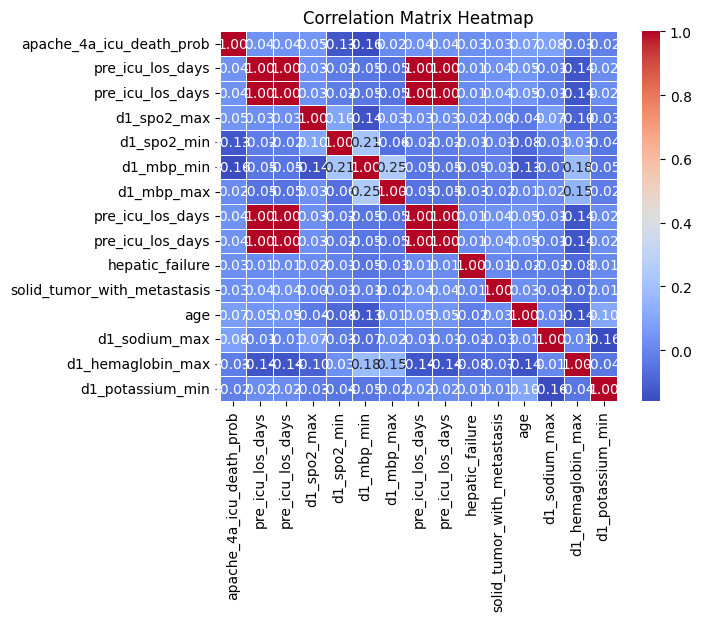

In [ ]:
correlation_matrix = numerical_data.corr()

sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
#check missing values again
data_cleaned.isnull().sum()

apache_4a_icu_death_prob       0
ethnicity                      0
pre_icu_los_days               0
d1_spo2_max                    0
d1_spo2_min                    0
d1_mbp_min                     0
d1_mbp_max                     0
pre_icu_los_days               0
hepatic_failure                0
solid_tumor_with_metastasis    0
icu_type                       0
gender                         0
icu_stay_type                  0
age                            0
d1_sodium_max                  0
d1_hemaglobin_max              0
d1_potassium_min               0
dtype: int64

In [ ]:
clean_df = data_cleaned[(data_cleaned['apache_4a_icu_death_prob'] >= 0)]

In [ ]:
# Define the bins for categorization.
# -np.inf represents negative infinity and np.inf represents positive infinity.
# This ensures that all possible values in the dataset are included.
bins = [-np.inf, 0.03, 0.2,np.inf]

# Define the labels for each bin.
names = ['low', 'moderate', 'high']

# Use the pandas `cut` function to segment and sort the 'suicides/100k pop' column values into discrete bins.
# The resultant categorical series (with labels as 'low', 'moderate', or 'high')
# is then assigned to a new column called 'suicide_level'.
clean_df['death_prob_level'] = pd.cut(clean_df['apache_4a_icu_death_prob'], bins, labels=names)

In [ ]:
clean_df.columns

Index(['apache_4a_icu_death_prob', 'ethnicity', 'pre_icu_los_days',
       'd1_spo2_max', 'd1_spo2_min', 'd1_mbp_min', 'd1_mbp_max',
       'pre_icu_los_days', 'hepatic_failure', 'solid_tumor_with_metastasis',
       'icu_type', 'gender', 'icu_stay_type', 'age', 'd1_sodium_max',
       'd1_hemaglobin_max', 'd1_potassium_min', 'death_prob_level'],
      dtype='object')

In [ ]:
#drop continuous column
clean_df = clean_df.drop('apache_4a_icu_death_prob', axis =1)

In [ ]:
# Map the descriptive categories in 'suicide_level' to integers and convert the column to integer data type
clean_df['death_prob_level'] = clean_df['death_prob_level'].replace({'low' : 0, 'moderate' : 1, 'high' : 2}).astype(int)

# Define the column that will be used as the target for modeling or analysis
target_column = 'death_prob_level'

# List of columns that contain categorical data
categorical_columns = ['gender', 'ethnicity', 'icu_stay_type', 'icu_type']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in clean_df.columns if c not in categorical_columns and c != target_column]

In [ ]:
#export clean data as excel
clean_df.to_excel('clean_data.xlsx', index=False)

KeyboardInterrupt: ignored

Set up model

In [ ]:
# Identifying categorical and numerical columns
categorical_cols = clean_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('death_prob_level')  # Removing the target variable from numerical columns

In [ ]:
# Splitting the data into training and test sets
X = clean_df.drop('death_prob_level', axis=1)
y = clean_df['death_prob_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a column transformer for preprocessing
ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Initializing the Gradient Boosting Classifier with specified parameters
random_forest = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)

# Creating a pipeline with preprocessing and the Random Forest classifier
model = Pipeline(steps=[('preprocessor', ct),
                           ('xg_boost', random_forest)])

Training and Initial Evaluation

In [ ]:
# Training the Gradient Boosting model on the training dataset
model = model.fit(X_train, y_train)

# Predicting on the training dataset and computing the accuracy
Y_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, Y_pred)
print(accuracy_train)

# Predicting on the test dataset and computing the accuracy
Y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, Y_pred)
print(accuracy_test)

0.63881540375513
0.6462277641137104


Hyperparameter tuning

In [ ]:
# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "xg_boost__n_estimators" : [50, 100, 200], #total number of trees/boosting rounds
    "xg_boost__learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
#skf = StratifiedKFold(n_splits=5)

#use non-stratified Kfold because outcome is balanced
kf = KFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=kf
)

# Fitting the GridSearchCV on the training data
random_search.fit(X_train, y_train)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xg_boost__learning_rate,param_xg_boost__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.966069,0.352727,0.087978,0.016664,0.1,50,"{'xg_boost__learning_rate': 0.1, 'xg_boost__n_...",0.633257,0.640069,0.634635,0.638925,0.653797,0.644645,0.62677,0.64107,0.641785,0.63678,0.639173,0.006857,1
1,3.768367,0.532015,0.168187,0.035749,0.1,100,"{'xg_boost__learning_rate': 0.1, 'xg_boost__n_...",0.633257,0.640069,0.634635,0.638925,0.653797,0.644645,0.62677,0.64107,0.641785,0.63678,0.639173,0.006857,1
3,2.004867,0.366026,0.088481,0.012810,0.2,50,"{'xg_boost__learning_rate': 0.2, 'xg_boost__n_...",0.633257,0.640069,0.634635,0.638925,0.653797,0.644645,0.62677,0.64107,0.641785,0.63678,0.639173,0.006857,1


In [ ]:
# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

{'xg_boost__learning_rate': 0.1, 'xg_boost__n_estimators': 50}

Refine model with optimal parameters

In [ ]:
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train, y_train)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_pred_test = model.predict(X_test)
test_accuracy = accuracy_score(y_test, Y_pred_test)
print(test_accuracy)
#did not improve lmao
#this was run a few times, got similar results each time
#accuracy not too diff from train to test, so likely not overfit

0.6391728990004433
0.6459417720070926
